In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm

from google.colab import files
import pickle

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 30
matplotlib.rcParams.update({'font.size': fontsize})
from matplotlib.pyplot import figure

In [3]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [4]:
!nvidia-smi

Wed May 24 10:21:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set-Up

In [5]:
# LENET parameters
RANDOM_SEED = 2147483647
LEARNING_RATE = 0.01 #0.0001 for MLP
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 2000000
BATCH_SIZE = 200
BATCH_SIZE_TEST = 1000


IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2. 
weight_decay = 0.01

setting_name=f"overparam_rs_{RANDOM_SEED}_lr_{LEARNING_RATE}_trainsize_{SUBSET_SIZE}_testsize_{TEST_SUBSET_SIZE}_niters_{N_ITERS}_batchsize_{BATCH_SIZE}_wd_{weight_decay}" 
setting_name

'overparam_rs_2147483647_lr_0.01_trainsize_50000_testsize_10000_niters_2000000_batchsize_200_wd_0.01'

In [6]:
use_cifar = True
use_mnist = False

In [7]:
!mkdir sgd_images

mkdir: cannot create directory ‘sgd_images’: File exists


# Data

In [8]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")



transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             #torchvision.transforms.CenterCrop(IMG_SIZE),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
     


In [9]:
!nvidia-smi

Wed May 24 10:21:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    15W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:

train_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=True, 
                                transform=transforms,
                                download=True)

test_dataset = datasets.CIFAR10(root='cifar_data', 
                                train=False, 
                                transform=transforms)


Files already downloaded and verified


In [11]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))
test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

In [12]:
test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=BATCH_SIZE_TEST, 
                          shuffle=False)

# Model

In [13]:
from torchvision.models import resnet50

def createmodel(k):
  torch.manual_seed(RANDOM_SEED)
  torch.cuda.manual_seed(RANDOM_SEED)
  return LeNet5(10, train_dataset[0][0].shape[0], k)

In [14]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, input_channels, k):
        super(LeNet5, self).__init__()
        
        self.part1 = nn.Sequential(            
            nn.Conv2d(in_channels=input_channels, out_channels=int(6*k), kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            )
        self.part2 = nn.Sequential(        
            nn.Conv2d(in_channels=int(6*k), out_channels=int(16*k), kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            )
        self.part3 = nn.Sequential(   
            nn.Conv2d(in_channels=int(16*k), out_channels=int(120*k), kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=int(120*k), out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

# Code

In [15]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)

In [16]:
#Binary Search for lambdas
def rate_function_BS(model, s_value):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, test_loader_batch)
  return aux_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_BinarySearch(log_p, s_value, low, high, epsilon):
  
  while (high - low) > epsilon:
      mid = (low + high) / 2
      print(mid)
      print(eval_log_p(log_p, low, s_value))
      print(eval_log_p(log_p, mid, s_value))
      print(eval_log_p(log_p, high, s_value))
      print("--")
      if eval_log_p(log_p, mid, s_value) < eval_log_p(log_p, high, s_value):
          low = mid
      else:
          high = mid

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]

import math
def aux_rate_function_golden_section_search(log_p, s_value, a, b, epsilon):
    """
    Maximizes a univariate function using the golden section search algorithm.

    Parameters:
        f (function): The function to minimize.
        a (float): The left endpoint of the initial search interval.
        b (float): The right endpoint of the initial search interval.
        tol (float): The error tolerance value.

    Returns:
        float: The x-value that minimizes the function f.
    """
    # Define the golden ratio
    golden_ratio = (torch.sqrt(torch.tensor(5).to(device)) - 1) / 2

    # Define the initial points
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)

    # Loop until the interval is small enough
    while abs(c - d) > epsilon:
        # Compute the function values at the new points
        fc = eval_log_p(log_p, c, s_value)
        fd = eval_log_p(log_p, d, s_value)

        # Update the interval based on the function values
        if fc > fd:
            b = d
            d = c
            c = b - golden_ratio * (b - a)
        else:
            a = c
            c = d
            d = a + golden_ratio * (b - a)

    # Return the midpoint of the final interval
    mid = (a + b) / 2
    return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [17]:
def eval_jensen(model, lambdas):
  log_p = get_log_p(device, model, test_loader_batch)
  return np.array(
      [
          (torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - torch.mean(lamb * log_p)).detach().cpu().numpy() for lamb in lambdas
       ])

def inverse_rate_function(model, lambdas, rate_vals):
  jensen_vals = eval_jensen(model, lambdas)

  return np.array([ np.min((jensen_vals + rate)/lambdas) for rate in rate_vals])


In [18]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0 
    losses = 0
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses += loss.detach().cpu().numpy() * targets.size(0)
      
    return correct, total, losses/total

In [19]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [20]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader):
    es = EarlyStopper(patience = 5)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)
    data_iter = iter(train_loader)
    iters_per_epoch = len(data_iter)
    print(iters_per_epoch)
    aux_loss = 1
    tq = tqdm(range(N_ITERS))
    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)
                

            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()

            tq.set_postfix({'Train cce': loss.detach().cpu().numpy()})


            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0 and it != 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.01 or es.early_stop(aux_loss):
                break
              aux_loss = 0

            

    return model

# Training

In [21]:
ks = np.insert(np.arange(0.5, 5, step = 0.5), [0, 0], [1/6, 1/3])

In [22]:
ks

array([0.16666667, 0.33333333, 0.5       , 1.        , 1.5       ,
       2.        , 2.5       , 3.        , 3.5       , 4.        ,
       4.5       ])

In [23]:
models = [createmodel(k).to(device) for k in ks]

In [24]:
n_params = []
for model in models:
  n = 0
  for parameter in model.parameters():
    n += parameter.flatten().size(0)
  n_params.append(n)

In [25]:
n_params

[3762,
 9741,
 18870,
 62006,
 130342,
 223878,
 342614,
 486550,
 655686,
 850022,
 1069558]

In [26]:
labels = ["ConvNN-3k", "ConvNN-9k", "ConvNN-18k", "ConvNN-62k", "ConvNN-130k", "ConvNN-223k","ConvNN-342k","ConvNN-486k","ConvNN-655k","ConvNN-850k","ConvNN-1069K"]

In [27]:
jet = plt.cm.get_cmap('Dark2')

<ipython-input-27-92d3b638b2ea>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Dark2')


In [ ]:
results = []
for i in range(len(models)):
  g_cuda = torch.Generator(device='cpu')
  g_cuda.manual_seed(RANDOM_SEED)
  loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          generator=g_cuda, 
                          shuffle=True)
  results.append(train(models[i], loader))
  with open(f'sgd_images/{setting_name}_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

250


  1%|          | 24500/2000000 [24:55<33:30:18, 16.38it/s, Train cce=1.6655376]


250


  1%|          | 21500/2000000 [21:29<32:57:53, 16.67it/s, Train cce=1.2737945]


250


  2%|▏         | 31500/2000000 [31:24<32:42:28, 16.72it/s, Train cce=1.1524645]


250


  2%|▏         | 35750/2000000 [35:37<32:37:41, 16.72it/s, Train cce=0.5261282]


250


  2%|▏         | 41250/2000000 [41:12<32:36:53, 16.68it/s, Train cce=0.21686867]


250


  2%|▏         | 42250/2000000 [44:26<34:19:36, 15.84it/s, Train cce=0.047759995]


250


  2%|▏         | 36250/2000000 [39:06<35:18:46, 15.45it/s, Train cce=0.016843438]


250


  1%|          | 16500/2000000 [17:54<35:53:25, 15.35it/s, Train cce=0.00977039]


250


  1%|          | 14000/2000000 [15:25<36:27:51, 15.13it/s, Train cce=0.00857931]


250


  1%|          | 11750/2000000 [13:10<37:10:37, 14.86it/s, Train cce=0.012424029]


250


  1%|          | 10750/2000000 [12:08<37:27:44, 14.75it/s, Train cce=0.008828224]


In [28]:
with open(f"sgd_images/{setting_name}_results.pickle", "rb") as handle:
  results = pickle.load(handle)

In [ ]:
train_loss = []
test_loss = []
for i in range(len(models)):
  loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  train_loss.append(eval(device, results[i],  loader, criterion)[2])
  test_loss.append(eval(device, results[i],  test_loader_batch, criterion)[2])

In [ ]:
print(train_loss)

[1.6496373896598815, 1.3278322134017944, 1.045444468975067, 0.5662441364526749, 0.23652358359098435, 0.04820906639844179, 0.016834399864077566, 0.009568517168983817, 0.009536842733621598, 0.009278404697775841, 0.00888342360407114]


In [ ]:
print(test_loss)

[1.6795321941375732, 1.4037856459617615, 1.2304759621620178, 1.1866214513778686, 1.4336361408233642, 2.0631648659706117, 2.078399097919464, 2.082019865512848, 1.9100995898246764, 1.84324551820755, 1.81825590133667]


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
X_Y_Spline = make_interp_spline(n_params, train_loss, k = 3)
X_ = np.linspace(n_params[0], n_params[-1], 500)
train_loss_ = X_Y_Spline(X_)

X_Y_Spline = make_interp_spline(n_params, test_loss, k = 3)
test_loss_ = X_Y_Spline(X_)

In [ ]:
fontsize = 30
matplotlib.rcParams.update({'font.size': fontsize})

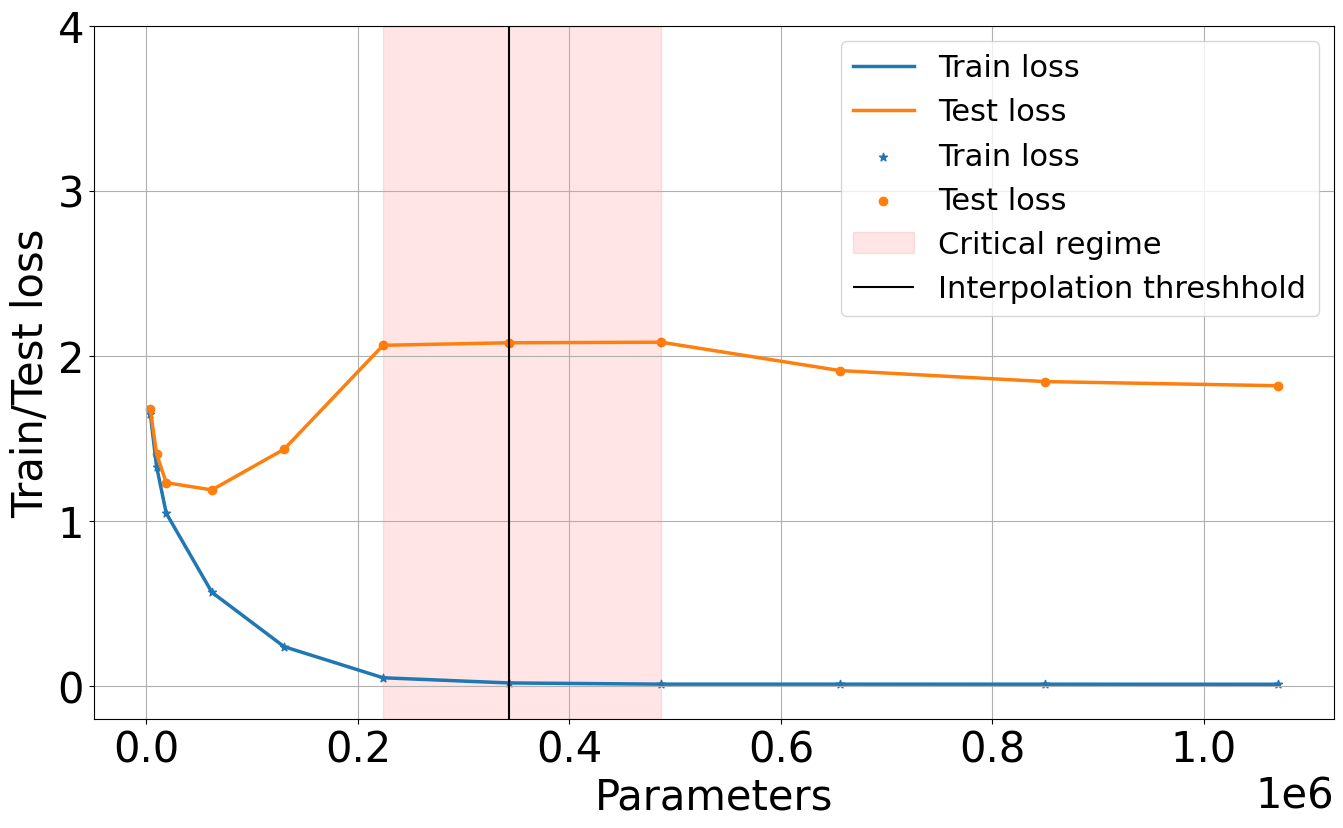

In [ ]:
plt.plot(n_params, train_loss, label = "Train loss", linewidth = 2.5)
plt.plot(n_params, test_loss, label = "Test loss", linewidth = 2.5)
#plt.plot(X_, train_loss_, linewidth = 2.5)
#plt.plot(X_, test_loss_, linewidth = 2.5)
plt.scatter(n_params, train_loss, marker = "*", label = "Train loss",)
plt.scatter(n_params, test_loss, marker = "o", label = "Test loss",)
plt.axvspan(n_params[5], n_params[7], alpha=0.1, color='red', label = "Critical regime")
plt.vlines(n_params[6], ymin = -0.2, ymax =4, label = "Interpolation threshhold", color = "black")
plt.grid()
plt.ylim(-0.2, 4)
plt.ylabel("Train/Test loss")
plt.xlabel("Parameters")
plt.legend(fontsize=20, prop={'size': 22}, loc = "upper right")
plt.savefig("sgd_images/double_descent.pdf", format = "pdf",bbox_inches='tight') 



# Figure 4: Jensen-Gap Functions Evolution

In [ ]:
for i in range(len(results)):
  print(labels[i])
  loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  print("Train", eval(device, results[i],  loader, criterion))
  print("Test", eval(device, results[i],  test_loader_batch, criterion))

ConvNN-3k
Train (20206, 50000, 1.649637393951416)
Test (3891, 10000, 1.6795321941375732)
ConvNN-9k
Train (26173, 50000, 1.3278322262763977)
Test (4889, 10000, 1.4037856459617615)
ConvNN-18k
Train (31484, 50000, 1.0454444737434387)
Test (5676, 10000, 1.2304759621620178)
ConvNN-62k
Train (40296, 50000, 0.5662441353797912)
Test (6293, 10000, 1.1866214513778686)
ConvNN-130k
Train (46705, 50000, 0.23652358281612396)
Test (6552, 10000, 1.4336361408233642)
ConvNN-223k
Train (49818, 50000, 0.0482090663164854)
Test (6472, 10000, 2.0631648659706117)
ConvNN-342k
Train (49988, 50000, 0.016834399793297053)
Test (6721, 10000, 2.078399097919464)
ConvNN-486k
Train (50000, 50000, 0.009568517023697496)
Test (6765, 10000, 2.082019865512848)
ConvNN-655k
Train (50000, 50000, 0.009536842839792371)
Test (6876, 10000, 1.9100995898246764)
ConvNN-850k
Train (49999, 50000, 0.009278404794633389)
Test (6906, 10000, 1.84324551820755)
ConvNN-1069K
Train (49999, 50000, 0.008883423570543527)
Test (6882, 10000, 1.81825

In [29]:
s_values = np.arange(0, 0.5, 0.01)
lambdas = np.arange(0, 10, 0.01)
Is = []


In [30]:
jensens = [eval_jensen(results[i].to(device), lambdas) for i in range(len(models))]

KeyboardInterrupt: ignored

In [31]:
rates = []
s_values = np.arange(0, 0.5, 0.01)

for i in range(len(results)):
  print(i)
  rates.append(np.array([rate_function_BS(results[i].to(device), s)[0] for s in s_values]))



0
1
2
3
4
5
6
7
8
9
10


In [35]:
markers = [8, 9, 10, 11, "+", "o", ">"]
colors = [jet(0), jet(1), jet(2), jet(3), jet(4), jet(5), jet(6)]

In [36]:
plt.rcParams['figure.figsize'] = (16, 9)
fontsize = 30

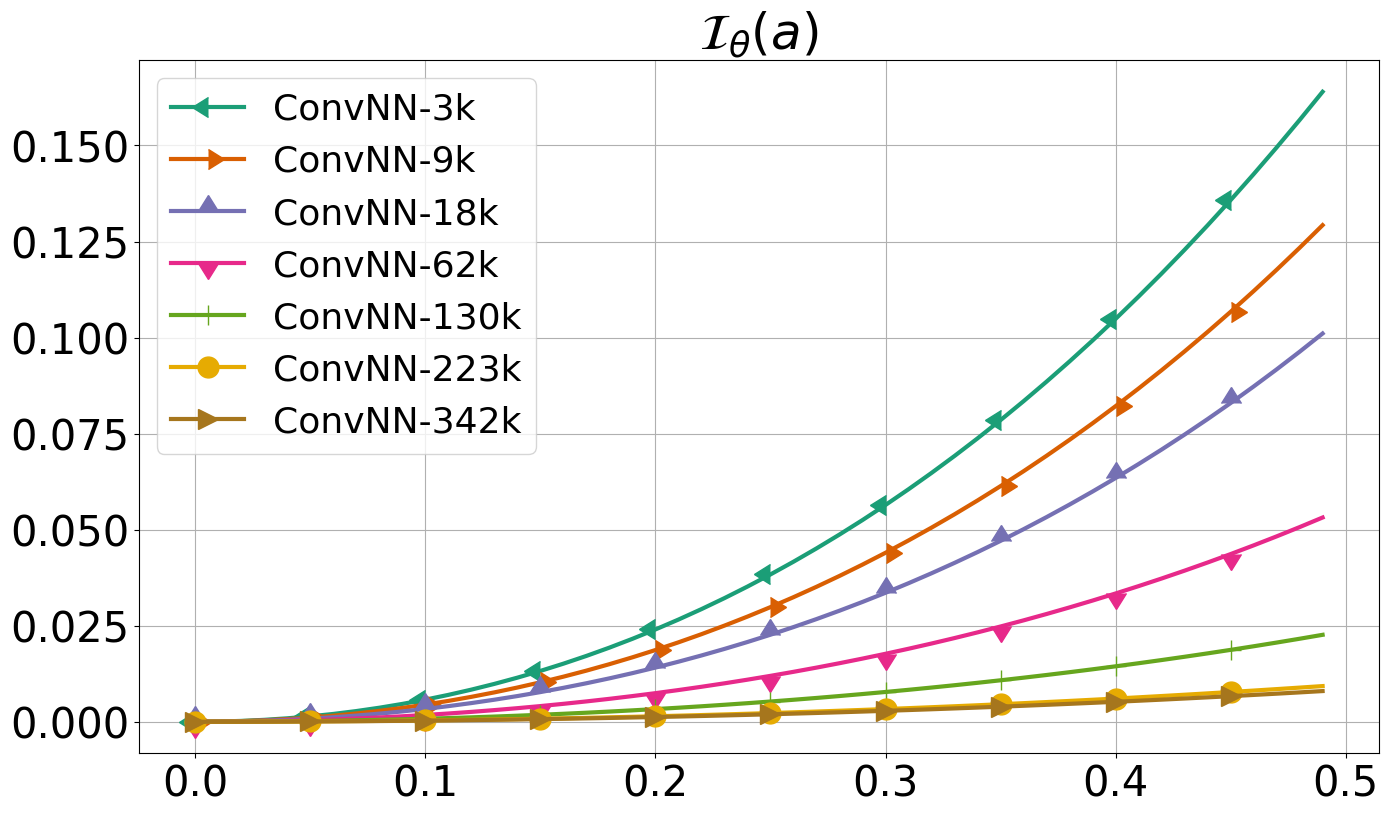

In [37]:
for idx, i in enumerate([0,1,2,3,4,5, 6]):
  plt.plot(s_values, rates[i], label=labels[i],linewidth=3, color = colors[idx], marker = markers[idx],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.grid()
plt.title(r"$\mathcal{I}_{\theta}(a)$")
plt.savefig("sgd_images/rate_1.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

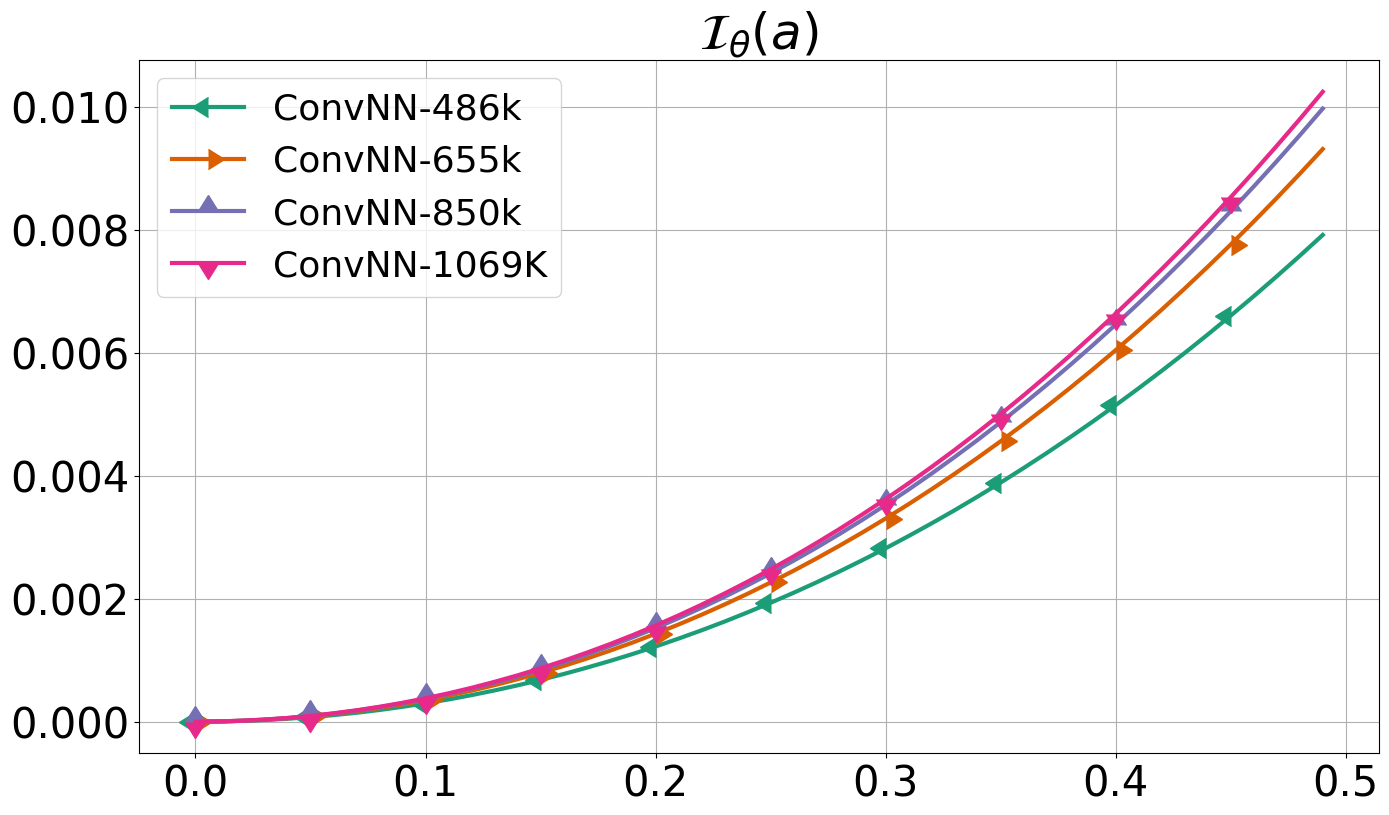

In [41]:
for idx, i in enumerate([7,8,9,10]):
  plt.plot(s_values, rates[i], label=labels[i],linewidth=3, color = colors[idx], marker = markers[idx],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.grid()
plt.title(r"$\mathcal{I}_{\theta}(a)$")
plt.savefig("sgd_images/rate_2.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

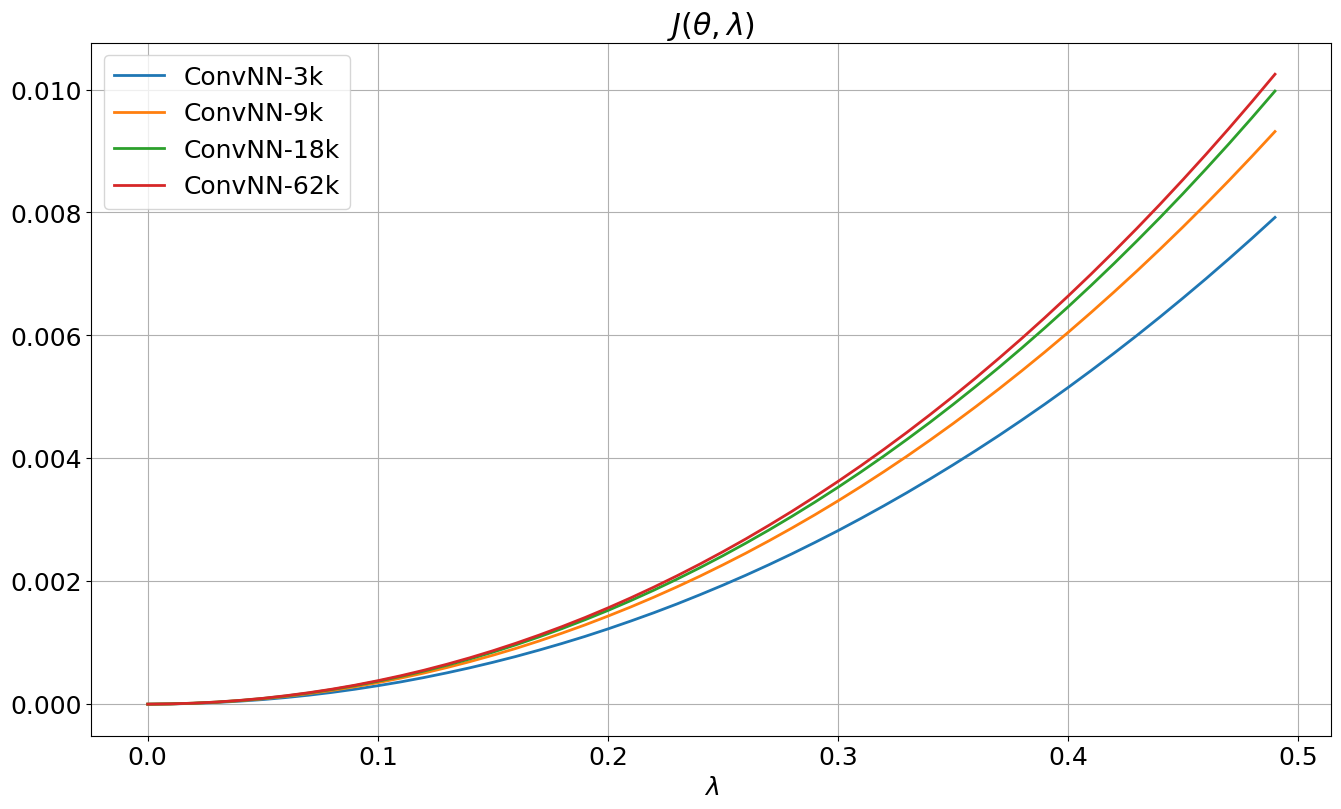

In [ ]:
plt.set_cmap("Dark2")
for i in range(len(Is)):
  plt.plot(s_values, Is[i], label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_1.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

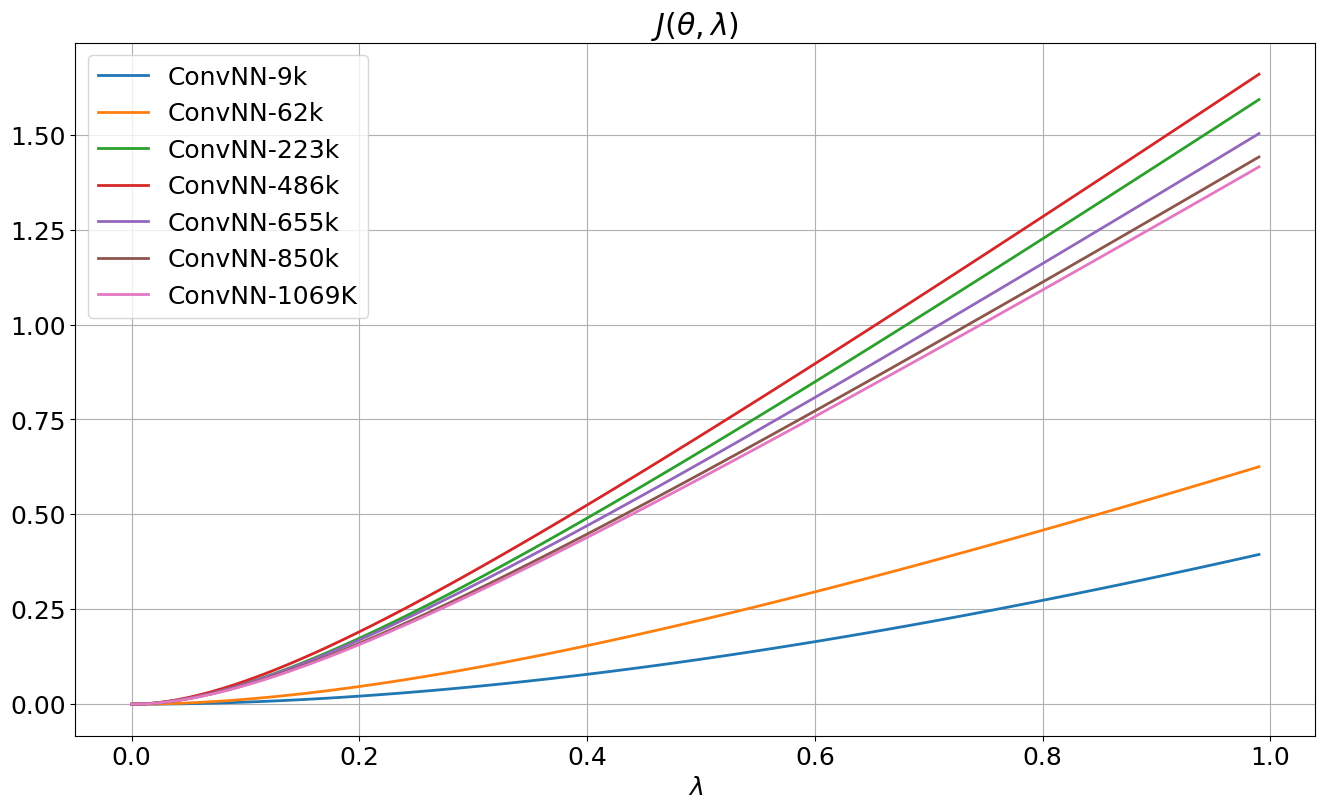

In [ ]:


plt.set_cmap("Dark2")
for i in [1, 3, 5, 7, 8, 9, 10]:
  plt.plot(lambdas, jensens[i], label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_1.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

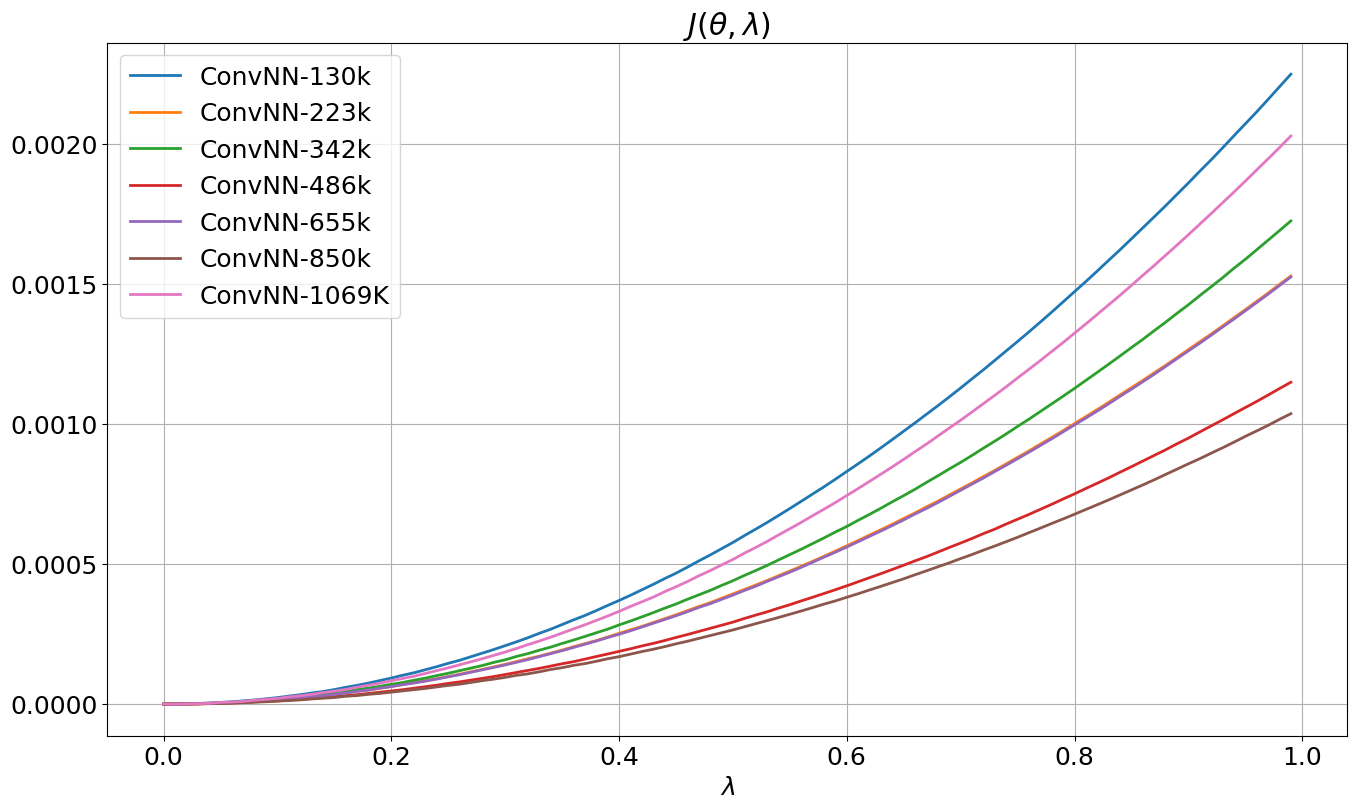

In [ ]:
plt.set_cmap("Dark2")
for i in range(4, len(models)):
  jensen = eval_jensen(models[i].to(device), lambdas)
  plt.plot(lambdas, jensen, label=labels[i] ,linewidth=2)


plt.legend()
plt.xlabel(r"$\lambda$")
#plt.xlim(0,0.5)
#plt.ylim(0,1)
plt.grid()
plt.title(r"$J(\theta,\lambda)$")
plt.savefig("sgd_images/jensen_overparameterization_2.pdf", format = "pdf",bbox_inches='tight') 
plt.show()

# Download Files

In [ ]:
!zip sgd_images/images.zip sgd_images/*.pdf

In [ ]:
files.download('sgd_images/images.zip')

In [ ]:
!ls -l sgd_images